# Lab 3 — recommender systems

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
plt.style.use("ggplot")

What does the data look like?

In [2]:
!hdfs dfs -cat /ix/ml-20m/ratings.txt | tail -n 2

{"movieId": 70286, "userId": 138493, "timestamp": 1258126944, "rating": 5.0}
{"movieId": 71619, "userId": 138493, "timestamp": 1255811136, "rating": 2.5}


### 3.4 Basic statistics

In [3]:
ratings = sc.textFile("/ix/ml-20m/ratings.txt").map(json.loads)

In [4]:
sum2 = lambda a, b: a + b
num_rating_per_user = ratings.map(lambda obj : (obj['userId'], 1)).reduceByKey(sum2).sortByKey().values().collect()
num_rating_per_movie = ratings.map(lambda obj : (obj['movieId'], 1)).reduceByKey(sum2).sortByKey().values().collect()

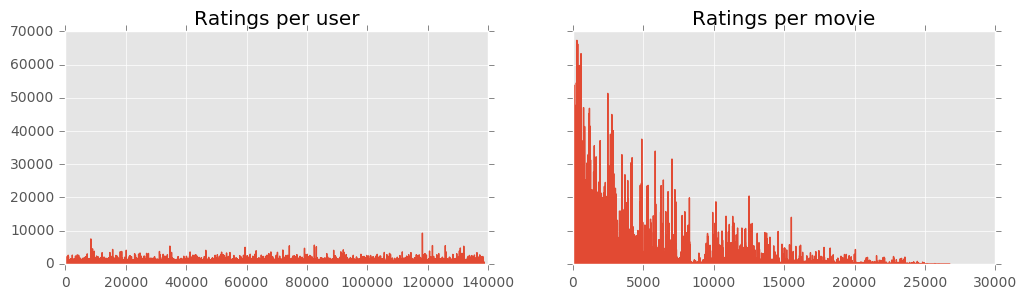

In [5]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 3), sharey=True)
ax1.plot(num_rating_per_user)
ax1.set_title("Ratings per user")
ax2.plot(num_rating_per_movie)
ax2.set_title("Ratings per movie")

We can see that the ratings per user is generally balanced, which is not the case for the ratings per movie. Some movies have much more ratings than others.

### 3.5 Partitioning the dataset

In [4]:
#Couldnt read file so I did it manually
my_ratings = sc.parallelize([
    {"movieId": 1, "rating": 5, "timestamp": 1491989698, "userId": 138494},
    {"movieId": 780, "rating": 3, "timestamp": 1491989704, "userId": 138494},
    {"movieId": 590, "rating": 4, "timestamp": 1491989707, "userId": 138494},
    {"movieId": 1210, "rating": 5, "timestamp": 1491989709, "userId": 138494},
    {"movieId": 648, "rating": 3, "timestamp": 1491989712, "userId": 138494},
    {"movieId": 344, "rating": 3, "timestamp": 1491989722, "userId": 138494},
    {"movieId": 165, "rating": 3, "timestamp": 1491989727, "userId": 138494},
    {"movieId": 153, "rating": 2, "timestamp": 1491989731, "userId": 138494},
    {"movieId": 597, "rating": 1, "timestamp": 1491989734, "userId": 138494},
    {"movieId": 1580, "rating": 3, "timestamp": 1491989743, "userId": 138494},
    {"movieId": 231, "rating": 2, "timestamp": 1491989750, "userId": 138494},
])

In [5]:
#Add my ratings
complete_ratings = ratings.union(my_ratings)

In [6]:
#Split the data set using the last digit of time stamp (80%-20%)
def less_than_eight(x):
    return x['timestamp'] %10 < 8

def more_than_eight(x):
    return not less_than_eight(x)

training_data = complete_ratings.filter(less_than_eight).cache()
validation_data = complete_ratings.filter(more_than_eight)

## Baseline Recommender System

### 3.6 Baseline model

In [7]:
def sumTuples(tup1, tup2):
    return (tup1[0] + tup2[0] , tup1[1] + tup2[1])
def RDDmean(rdd):
    seqOp = lambda acc, rating: (acc[0] + rating, acc[1] + 1)
    total, count = rdd.aggregate((0, 0), seqOp, sumTuples)
    return total / count

In [8]:
global_average = RDDmean(training_data.map(lambda j: j['rating']))
global_average

3.5255161464366283

In [9]:
# (uId, (rating-mu, 1)) then (uid, (sum of ratings of score, count)) then (uid, alpha_u)
pairCreator = lambda j: (j['userId'], (j['rating'] - global_average, 1))
alphas = training_data.map(pairCreator)\
                      .reduceByKey(sumTuples)\
                      .mapValues(lambda tup: tup[0] / tup[1]).cache()

In [10]:
NP = training_data.getNumPartitions()

In [11]:
pairCreator = lambda j: (j['userId'],  (j['movieId'], j['rating']))
# flatten used to map (userId, ((movieId, rating), alpha)) to (movieId, (rating, alpha))
flatten = lambda t: (t[1][0][0], (t[1][0][1], t[1][1]))
seqOp = lambda acc, tr: (acc[0] + tr[0] - tr[1] - global_average, acc[1] + 1)

with_alpha = training_data.map(lambda j: (j['userId'],  (j['movieId'], j['rating'])))\
                          .join(alphas)\
                          .map(flatten)
betas = with_alpha.aggregateByKey((0,0), seqOp, sumTuples, numPartitions=NP)\
                  .mapValues(lambda t: t[0] / t[1]).cache()

In [12]:
default_alpha = RDDmean(alphas.values())
default_beta = RDDmean(betas.values())
(default_alpha, default_beta)

(0.10166146018546321, -0.20450786155878353)

In [13]:
placeholder = validation_data.map(lambda j: (j['userId'], (j['movieId'], 1)))

def fixEmptyUser(t):
    """ Replaces missing alphas with default value and converts to format:
    (movieId, (userId, alpha))
    """
    alpha = t[1][1] if not t[1][1] == None else default_alpha
    return (t[1][0][0], (t[0], alpha))

withAlphas = placeholder.leftOuterJoin(alphas, numPartitions=NP)\
                        .map(fixEmptyUser)

def fixEmptyMovies(t):
    """ Replaces missing betas with default value and converts to format:
    ((userId, movieId), (alpha, beta))
    """
    beta = default_beta if t[1][1] is None else t[1][1]
    return ((t[1][0][0], t[0]) , (t[1][0][1], beta))

userMovieToBiases = withAlphas.leftOuterJoin(betas, numPartitions=NP)\
                              .map(fixEmptyMovies)

compute_single_rank = lambda biases: biases[0] + biases[1] + global_average

scores = userMovieToBiases.map(lambda t: (t[0][0], t[0][1], compute_single_rank(t[1])))

### 3.5 Evaluation

In [14]:
val = validation_data.map(lambda j: ((j['userId'], j['movieId']), j['rating']))

In [15]:
import math
def error(rdd):
    tmp = rdd.map(lambda t: ((t[0], t[1]), t[2])) # ((userId, movieId), rating)
    mixed = val.join(tmp)
    byUser = mixed.map(lambda t: (t[0][0], (t[1][1], t[1][0]))) # (userId, (computedScore, scoreInValidation))
    numUsers = byUser.keys().distinct().count()
    square = lambda x: x*x
    seqOp = lambda acc, t: (acc[0] + square(t[0] - t[1]) , acc[1] + 1)
    return byUser.aggregateByKey((0, 0), seqOp, sumTuples)\
                 .map(lambda t: math.sqrt(t[1][0] / t[1][1]))\
                 .sum() / numUsers

In [16]:
baseline_error = error(scores)
baseline_error

0.8669177244805794

## Matrix Factorization Model

The rank is related to the number of hidden factors in the data. Choosing a rank too small may lead to underfitting (but provides better performances) while a too small vlaue may lead to overfitting (and will run slower)

In [17]:
from pyspark.mllib.recommendation import ALS

### 3.8 Regularization

In [19]:
ratings = training_data.map(lambda j: (j['userId'], j['movieId'], j['rating']))

In [20]:
# Learning a model
model = ALS.train(ratings, rank=10, iterations=10, lambda_=10**(-4))

In [21]:
scores = model.predictAll(validation_data.map(lambda j: (j['userId'], j['movieId'])))

In [26]:
scores.take(3)

[Rating(user=92835, product=4069, rating=4.41576665949823),
 Rating(user=92835, product=4015, rating=4.199127618646245),
 Rating(user=92835, product=4149, rating=4.012437945868928)]

In [22]:
error(scores)

0.8822560895364192

The baseline predictor was more accurate. EXPLAIN THE PHENOMEN?

In [30]:
# Change lambda now to 10.0
scores = ALS.train(ratings, rank=10, iterations=10, lambda_=10.0)\
            .predictAll(validation_data.map(lambda j: (j['userId'], j['movieId'])))

In [31]:
error(scores)

3.74625182983579

The error is 4 times bigger!

This is due to the fact that we are trying to minimize the cost function and the regularizer: $\underset{\theta}{\min} f_\theta(x) + \lambda g(\theta)$. $\lambda$ too large leads to overgeneralization while $\lambda$ leads to overfitting. We have to choose a better $\lambda$!

In [20]:
# HYPER SLOW; DO NOT RUN
# Find the value that minimizes the error
logspace = np.logspace(-6, 1, num=10)
i = 0
err = 10
evaluate_als = lambda lam: error(ALS.train(ratings, rank=10, iterations=10, lambda_=lam)\
                                    .predictAll(validation_data.map(lambda j: (j['userId'], j['movieId']))))
for lambda_ in logspace:
    err = evaluate_als(lambda_)
    print('Lambda =', lambda_,'-> error =', err)
    i += 1

Lambda = 1e-06 -> error = 0.9742331742502927
Lambda = 5.99484250319e-06 -> error = 0.9445541008977902
Lambda = 3.5938136638e-05 -> error = 0.9050133114464965
Lambda = 0.000215443469003 -> error = 0.8739900312949199
Lambda = 0.00129154966501 -> error = 0.8553959634941466
Lambda = 0.00774263682681 -> error = 0.8409551235972661
Lambda = 0.0464158883361 -> error = 0.8066278621683064
Lambda = 0.278255940221 -> error = 0.8899771696305591
Lambda = 1.6681005372 -> error = 1.8942200711599115
Lambda = 10.0 -> error = 3.7462518298357894


In [24]:
# HYPER SLOW; DO NOT RUN
space = np.linspace(0.008, 0.06, num=30, endpoint=True)

for lambda_ in space:
    err = evaluate_als(lambda_)
    print('Lambda =', lambda_,'-> error =', err)
    

Lambda = 0.008 -> error = 0.8386333221899025
Lambda = 0.00979310344828 -> error = 0.8354929443233008
Lambda = 0.0115862068966 -> error = 0.8333807202176128
Lambda = 0.0133793103448 -> error = 0.8297997744481613
Lambda = 0.0151724137931 -> error = 0.8265318145079906
Lambda = 0.0169655172414 -> error = 0.8257533179446314
Lambda = 0.0187586206897 -> error = 0.8248588219635358
Lambda = 0.0205517241379 -> error = 0.8203681765757553
Lambda = 0.0223448275862 -> error = 0.8173285962537548
Lambda = 0.0241379310345 -> error = 0.8152874304493991
Lambda = 0.0259310344828 -> error = 0.8108441434820374
Lambda = 0.027724137931 -> error = 0.811554349896495
Lambda = 0.0295172413793 -> error = 0.8127074129069494
Lambda = 0.0313103448276 -> error = 0.8101553230986321
Lambda = 0.0331034482759 -> error = 0.8060689040609152
Lambda = 0.0348965517241 -> error = 0.809024540425495
Lambda = 0.0366896551724 -> error = 0.8085968097720054
Lambda = 0.0384827586207 -> error = 0.8096395978135982
Lambda = 0.04027586206

### 3.9 Recommendation

In [21]:
!hdfs dfs -cat /ix/ml-20m/movies.txt | tail -n 2
titles = sc.textFile("/ix/ml-20m/movies.txt")\
           .map(json.loads)\
           .map(lambda j: (j['movieId'], j['title']))\
           .collectAsMap()

{"genres": ["(no genres listed)"], "movieId": 131260, "title": "Rentun Ruusu (2001)"}
{"genres": ["Adventure", "Fantasy", "Horror"], "movieId": 131262, "title": "Innocence (2014)"}


In [22]:
titles

{131072: 'Jesus liebt mich (2012)',
 1: 'Toy Story (1995)',
 2: 'Jumanji (1995)',
 3: 'Grumpier Old Men (1995)',
 4: 'Waiting to Exhale (1995)',
 5: 'Father of the Bride Part II (1995)',
 6: 'Heat (1995)',
 7: 'Sabrina (1995)',
 8: 'Tom and Huck (1995)',
 9: 'Sudden Death (1995)',
 10: 'GoldenEye (1995)',
 11: 'American President, The (1995)',
 12: 'Dracula: Dead and Loving It (1995)',
 13: 'Balto (1995)',
 14: 'Nixon (1995)',
 15: 'Cutthroat Island (1995)',
 16: 'Casino (1995)',
 17: 'Sense and Sensibility (1995)',
 18: 'Four Rooms (1995)',
 19: 'Ace Ventura: When Nature Calls (1995)',
 20: 'Money Train (1995)',
 21: 'Get Shorty (1995)',
 22: 'Copycat (1995)',
 23: 'Assassins (1995)',
 24: 'Powder (1995)',
 25: 'Leaving Las Vegas (1995)',
 26: 'Othello (1995)',
 27: 'Now and Then (1995)',
 28: 'Persuasion (1995)',
 29: 'City of Lost Children, The (Cité des enfants perdus, La) (1995)',
 30: 'Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)',
 31: 'Dangerous Minds (1995)',
 32: 'Twe

# -

In [40]:
#Predict rating of userId 'user' for movieId 'movie' from given training data 'data'
#TODO: add avg values when no rating per user/movie in a and b!!!
#Note: some users / movies do not have any ratings. Use sensible default values for au and bm
def global_rating(data):
    N = data.map(lambda obj : obj['rating'])
    u = N.sum() / N.count()
    return u

def alpha_u(data, userId, u):
    Nu = data.filter(lambda x : x['userId'] == userId).map(lambda obj : obj['rating'])
    a_u = Nu.map(lambda x : x - u).sum() / Nu.count()
    return a_u

def beta_m(data, movieId, a_u_list, u):
    Nm = data.filter(lambda x : x['movieId'] == movieId).map(lambda obj : obj['rating'])
    b_m = Nm.map(lambda x : x - a_u_list - u).sum() / Nm.count()
    return b_m

In [43]:
users = training_data.map(lambda obj : obj['userId'])
movies = training_data.map(lambda obj : obj['movieId']).persist()
u = global_rating(training_data)

In [44]:
alpha_u_list = users.map(lambda x : (x, alpha_u(training_data, x, u)))
print(alpha_u_list.take(1))
#beta_m = movies.map(lambda x, )

Exception: It appears that you are attempting to broadcast an RDD or reference an RDD from an action or transformation. RDD transformations and actions can only be invoked by the driver, not inside of other transformations; for example, rdd1.map(lambda x: rdd2.values.count() * x) is invalid because the values transformation and count action cannot be performed inside of the rdd1.map transformation. For more information, see SPARK-5063.

In [39]:
print(predicted_rating(training_data, 138494, 590))

3.7323296579022185


This model has 3 parameters, the dataset to use, the userId and the movieId.

In [31]:
print(validation_data.map(lambda x : (x['userId'], x['movieId'])).take(1))
print(len(validation_data.collect()))

[(1, 32)]
4001326


In [24]:
#Predict ratings of every user/movie in validation set
predicted_set = validation_data.map(lambda x : (x['userId'], x['movieId']))
for user in validation_data.map(lambda x : x['userId']):
    for movie in validation_data.map(lambda x : x['movieId']):
        r_um = predicted_rating()

3.8666304178965385


In [ ]:
# Takes in RDD tripplet of userId, movieId and rating and compute the error obtained with prediction
def error(userId, movieId, rating)